Traffic columns: ['DateTime', 'Junction', 'Vehicles', 'ID']
Weather columns: ['utc_timestamp', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal', 'BE_temperature', 'BE_radiation_direct_horizontal', 'BE_radiation_diffuse_horizontal', 'BG_temperature', 'BG_radiation_direct_horizontal', 'BG_radiation_diffuse_horizontal', 'CH_temperature', 'CH_radiation_direct_horizontal', 'CH_radiation_diffuse_horizontal', 'CZ_temperature', 'CZ_radiation_direct_horizontal', 'CZ_radiation_diffuse_horizontal', 'DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal', 'DK_temperature', 'DK_radiation_direct_horizontal', 'DK_radiation_diffuse_horizontal', 'EE_temperature', 'EE_radiation_direct_horizontal', 'EE_radiation_diffuse_horizontal', 'ES_temperature', 'ES_radiation_direct_horizontal', 'ES_radiation_diffuse_horizontal', 'FI_temperature', 'FI_radiation_direct_horizontal', 'FI_radiation_diffuse_horizontal', 'FR_temperature', 'FR_radiation_dir

/tmp/ipython-input-1843677526.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged.fillna(method="ffill", inplace=True)


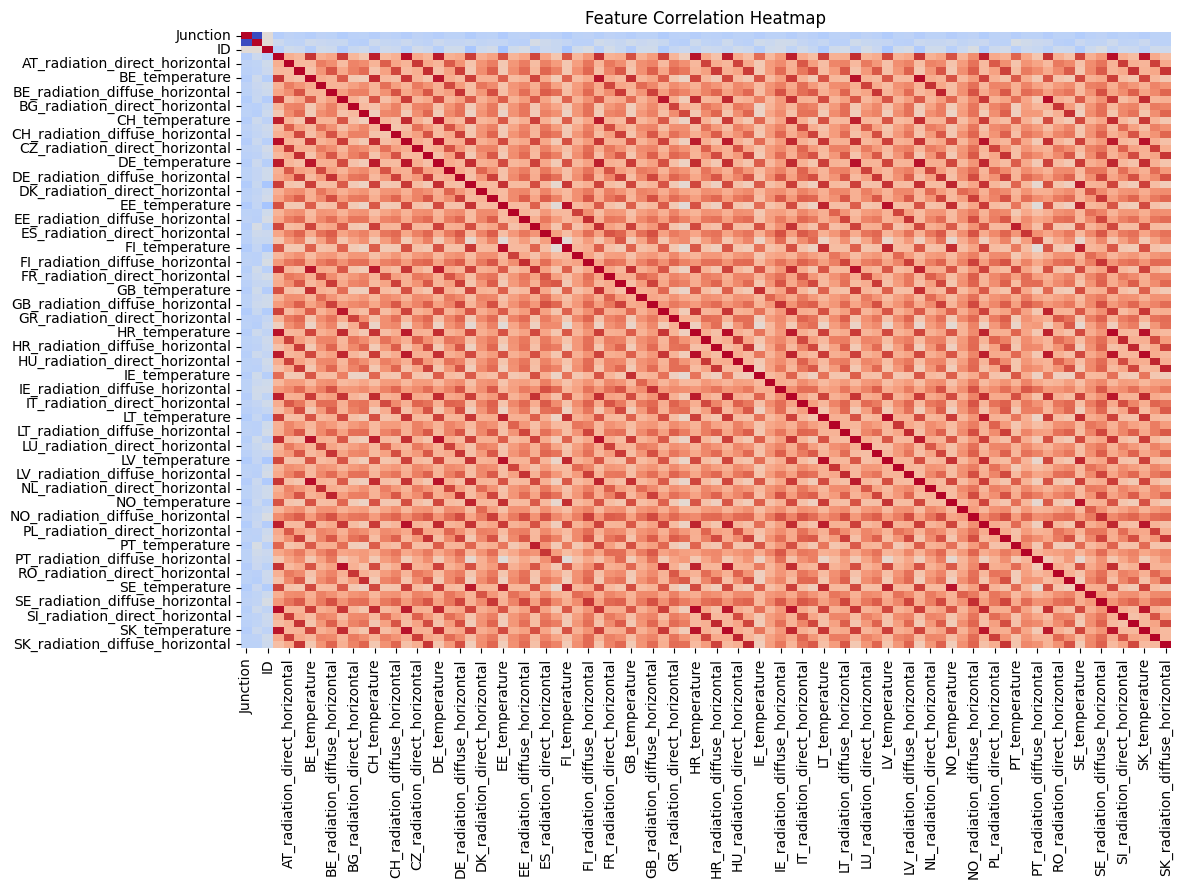

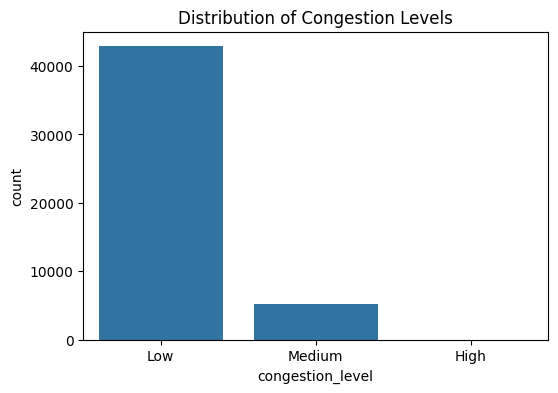

Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00      8573
      Medium       1.00      1.00      1.00      1051

    accuracy                           1.00      9624
   macro avg       1.00      1.00      1.00      9624
weighted avg       1.00      1.00      1.00      9624

Confusion Matrix:
 [[8573    0]
 [   0 1051]]


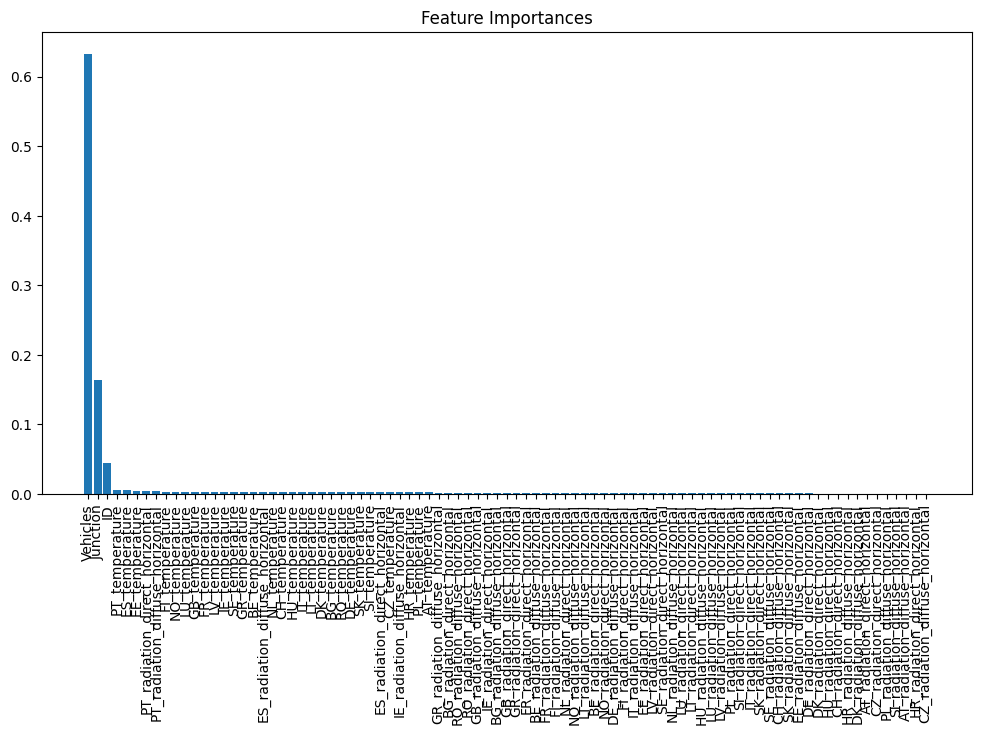

In [ ]:
# ==========================================
# Traffic Congestion Analysis + Prediction
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -------------------------
# 1. Load the datasets
# -------------------------
traffic = pd.read_csv("traffic.csv")
weather = pd.read_csv("weather_data_filtered.csv")

print("Traffic columns:", traffic.columns.tolist())
print("Weather columns:", weather.columns.tolist())

# ==========================================
# 2. Data Preprocessing
# ==========================================

# Convert both to datetime (without timezone mismatch)
traffic["DateTime"] = pd.to_datetime(traffic["DateTime"])
weather["utc_timestamp"] = pd.to_datetime(weather["utc_timestamp"]).dt.tz_localize(None)

# Merge on DateTime
merged = pd.merge(traffic, weather, left_on="DateTime", right_on="utc_timestamp", how="inner")

print("Merged dataset shape:", merged.shape)
print("Merged columns:", merged.columns.tolist())

# Drop duplicate timestamp column
merged.drop(columns=["utc_timestamp"], inplace=True)

# ==========================================
# Define Target Variable for Prediction
# ==========================================

# Example: create congestion_level based on number of vehicles
# (You can adjust thresholds as per dataset distribution)
merged["congestion_level"] = pd.cut(
    merged["Vehicles"],
    bins=[-1, 50, 200, 1000],
    labels=["Low", "Medium", "High"]
)

print("Congestion level distribution:\n", merged["congestion_level"].value_counts())

# ==========================================
# Handle Missing Values
# ==========================================
print("Missing values before:\n", merged.isnull().sum().sum())
merged.fillna(method="ffill", inplace=True)
print("Missing values after:\n", merged.isnull().sum().sum())

# ==========================================
# Encode Categorical Variables
# ==========================================
categorical_cols = merged.select_dtypes(include=["object"]).columns
merged = pd.get_dummies(merged, columns=categorical_cols, drop_first=True)

# ==========================================
# Feature/Target Split
# ==========================================
X = merged.drop(["congestion_level", "DateTime"], axis=1)
y = merged["congestion_level"]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 4. Exploratory Data Analysis
# ==========================================

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribution of Congestion Levels")
plt.show()

# ==========================================
# 5. Model Training & Evaluation
# ==========================================

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()